In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from glob import glob1
import pandas as pd
from scipy.io import loadmat

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 30})
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['font.family']='arial'
params = {'legend.edgecolor': '0',
          'lines.markersize' : 5,
          'legend.borderaxespad': 1.5,
          'legend.fancybox': False,
          'legend.fontsize': 25.0,
          'legend.framealpha': 0.5,
          'legend.labelspacing': 0.3,
          'legend.markerscale': 1.0,
          'figure.figsize': (10, 8),
         'axes.labelsize': 30,
         'axes.titlesize': 30,
         'axes.linewidth': 3,
         'axes.xmargin': 0.03,
         'axes.ymargin': 0.03,
         'xtick.direction': 'in',
         'xtick.labelsize': 30,
         'xtick.major.pad': 10,
         'xtick.major.size': 10,
         'xtick.major.width': 3,
         'xtick.minor.pad': 10,
         'xtick.minor.size': 5,
         'xtick.minor.visible': True,
         'xtick.minor.width': 2,
         'xtick.top': True,
         'ytick.direction': 'in',
         'ytick.labelsize': 30,
         'ytick.major.pad': 10,
         'ytick.major.size': 10,
         'ytick.major.width': 3,
         'ytick.minor.pad': 10,
         'ytick.minor.size': 5,
         'ytick.minor.visible': True,
         'ytick.minor.width': 2,
         'ytick.right': True,}
plt.rcParams.update(params)

In [3]:
def findall(p, s):
    '''Yields all the positions of
    the pattern p in the string s.'''
    i = s.find(p)
    while i != -1:
        yield i
        i = s.find(p, i+1)
        
def Gaussianfit(x,y,ax=None,isplot=False):
    from lmfit.models import GaussianModel
    mod = GaussianModel()
    params = mod.guess(y,x=x)
    result = mod.fit(y,params,x=x)
    if isplot:
        if ax is None:
            f = plt.figure()
            ax = f.add_subplot(111)
        ax.plot(x,y,'-o',alpha=0.75,color='navy')
        dummyx = np.linspace(min(x),max(x),1000)
        ax.plot(dummyx,mod.eval(result.params,x=dummyx),color='darkorange')
        try:
            ax.set_title('FWHM = %.3f +- %.3f'%(result.params['fwhm'].value,result.params['fwhm'].stderr))
        except:
            ax.set_title('FWHM = %.3f +- %.3f'%(result.params['fwhm'].value,0))
    return result, mod
    

In [4]:
def fasterloadtxt(filename):
    '''
    using pandas to speed up file reading
    '''
    import pandas as pd
    df = pd.read_csv(filename,sep=' ', header=None)
    return df.values.flatten()

In [5]:
def npz2mat(filename_npz):
    from scipy.io import savemat
    data = np.load(filename_npz)
    mdic = {"time_in_s": data['time_s'], 'spectrum': data['spectra'],'frequency_Hz': data['freq'] }
    savemat(filename_npz[:-4]+'.mat',mdic)

# filename = r'Z:\qfc\users\Armin\Ben_spectrums\12042022_QSIMQFC_beat_001.npz'
# npz2mat(filename)

In [6]:
directory = r'Z:\qfc\users\Armin\vibration_measurements'
directory = r'Z:\qfc\users\Armin\vibration_measurements\speaker_data'
flst = glob1(directory,'*22042022_QSIMQFC_beat_10minutes*.npz*')
flst2 = glob1(directory,'*0503*vibration_data_*.npz')
flst2 = glob1(directory,'*.txt*')
flst2khz = glob1(directory,'*2kHz*.npz*')
flst = list( set(flst) - set(flst2khz) )
# flst = flst2khz
# flst = [flst[0],flst[1],flst[2],flst[-2],flst[-1]]
# flst = [flst[7],flst[1],flst[8],flst[4]]
# flst = [flst[4],flst[5],flst[0],flst[8]]
# flst = [flst[1],flst[2]]
flst,flst2

([],
 ['10052022_vibration_response_of_vibrometer_inside_speaker.txt',
  'C1vibrationcavbread00000.txt',
  'C1vibrationcavbread29hz00000.txt',
  'C1vibrationcavbread29hz00001.txt',
  'C1vibrationcavbread29hz00002.txt',
  'C1vibrationcavbread58hz00000.txt',
  'C1vibrationcavbread87hz00000.txt',
  'C1vibrationcavbread91hz00000.txt',
  'C1vibrationcavbread92hz00000.txt',
  'C1vibrationcavbreadnodevice00000.txt',
  'C1vibrationtopwood00000.txt',
  'C1vibrationtopwood00001.txt',
  'C1vibrationtopwood29hz00000.txt',
  'C1vibrationtopwood29hz00001.txt',
  'C1vibrationtopwood29hz00002.txt',
  'C1vibrationtopwood92hz00000.txt',
  'C1vibrationtopwoodnodevice00000.txt'])

In [16]:
def get_cavity_drift(times,freq,spectra,ax=None):
    from lmfit.models import LinearModel
    center = np.zeros(len(spectra))
    dcenter = np.zeros(len(spectra))
    for j in range(len(spectra)):
        result,mod = Gaussianfit(x=freq,y=spectra[j],ax=None,isplot=False)
        center[j] = result.params['center'].value
        dcenter[j] = result.params['center'].stderr
    if ax is not None:
        mod = LinearModel()
        params = mod.guess(center,x=times)
        result = mod.fit(center,params,x=times)
        
        ax.errorbar(times,center,yerr=dcenter,fmt='o',color='navy',alpha=0.75,zorder=0)
        ax.plot(times,result.best_fit,color='darkorange',zorder=1)
        
        ax.set_title('Drift rate is %.0f (%.0f) mHz/s'%(result.params['slope'].value*1e3,1e3*result.params['slope'].stderr))
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Center (Hz)')

In [17]:

isfit = True
plotlog= False
combineplot = not True
showlegend = False
import matplotlib.ticker
xfreq = []
yamp = []
pgain =[]
egain = []
for j in range(len(flst)):
    filename = os.path.join(directory,flst[j])
    filestr=flst[j]
    data = np.load(filename)
    freq = data['freq'][0]; spectra = data['spectra']; times = data['time_s']
    try:
        piezo_gain = int(filestr[filestr.find('beat_main_gain')+14:filestr.find('beat_main_gain')+15])
    except:
        piezo_gain = 0
    try:
        eom_gain = int(filestr[filestr.find('eom_main_gain')+13:filestr.find('eom_main_gain')+14])
    except:
        eom_gain=0
    last_spectra = spectra[0]
    first_spectra = spectra[-1]
    average_spectra = spectra.mean(axis=0)

    if not combineplot:
        f = plt.figure(figsize=(10,8*2))
        f.subplots_adjust(hspace=0.5)
        ax0 = f.add_subplot(311)
        ax0.set_ylabel('Time (s)')
        ax0.set_xlabel('Freq (Hz)')
        ax0.pcolormesh(freq,times-times[0],spectra,cmap='inferno_r')
        
        ax00 = f.add_subplot(312)
        get_cavity_drift(times-times[0],freq,spectra,ax=ax00)
        ax1 = f.add_subplot(313)
        if isfit:
            Gaussianfit(freq,average_spectra,ax=ax1,isplot=isfit)
            xtext = 1000
            piezovalue = 0.75
            eomvalue = 0.65
        else:
            ax1.plot(freq,average_spectra,color='navy')
            xtext = 250000
            piezovalue = 0.1
            eomvalue = 0.01
        if showlegend:
            ax1.text(np.median(freq)-xtext, max(average_spectra)*piezovalue,'Piezo Gain=%s'%piezo_gain)
            ax1.text(np.median(freq)-xtext, max(average_spectra)*eomvalue,'EOM Gain=%s'%eom_gain)
        ax1.set_xlabel('Freq (Hz)')
        if plotlog:
            ax1.set_yscale('log')
            locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
            ax1.yaxis.set_minor_locator(locmin)
            ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        else:
            ax1.set_ylim(bottom=0)
        ax1.set_ylabel('Amplitude')

        f.savefig(filename[:-4]+'_average.png',dpi=100,bbox_inches='tight',facecolor='white')
        plt.close('all')
    else:
        xfreq.append(freq)
        yamp.append(average_spectra)
        pgain.append(piezo_gain)
        egain.append(eom_gain)
        fnc =['off','off','off','off']
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        if j==len(flst)-1:
            f = plt.figure()
            ax1 = f.add_subplot(111)
            for k in range(len(xfreq))[::-1]:
                if isfit:
                    res,mod = Gaussianfit(xfreq[k],yamp[k],ax=ax1,isplot=False)
                    print (res.params['fwhm'])
                    ax1.plot(xfreq[k]-k*300,mod.eval(res.params,x=xfreq[k]),color=colors[k])
                    alpha =0.5
                else:
                    alpha=1
                try:
                    ax1.plot(xfreq[k]-k*300,yamp[k],label='Gain: Piezo=%i, EOM=%i, fnc=%s'%(pgain[k],egain[k],fnc[k]),alpha=alpha,color=colors[k])
                except Exception as ep:
                    print (ep)
                    ax1.plot(xfreq[k]-k*300,yamp[k],label='Gain: Piezo=%i, EOM=%i, fnc=%s'%(pgain[k],egain[k],"off"),alpha=alpha,color=colors[k])

            ax1.set_xlabel('Freq (Hz)')
            if plotlog:
                ax1.set_yscale('log')
                locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=12)
                ax1.yaxis.set_minor_locator(locmin)
                ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
            else:
                ax1.set_ylim(bottom=0)
            if showlegend:
                ax1.legend(loc='upper right',borderaxespad=0)
            ax1.set_ylabel('Amplitude')
            f0 = np.median(xfreq[0])
#             ax1.set_xlim(f0-30000,f0+30000)
            f.savefig(filename[:-5]+'_comparison.png',dpi=100,bbox_inches='tight',facecolor='white')

# Vibrometer data

In [165]:
def load_vibrometer_data(filename,isplot=False,labels=['side wooden box','cavity breadboard'],issaved=False):
    from fourier import fourier2
    try:
        data = np.load(filename)
        timeosc = data['timeosc']
        chn2 = data['chn2']
        chn4 = data['cn4']
    except:
        data = np.loadtxt(filename,skiprows=5,delimiter=',')
        timeosc = data[:,0]
        chn2 = data[:,1]
    
    if isplot:
        f = plt.figure(figsize=(10*2.2,8*1))
        f.subplots_adjust(hspace=0.35,wspace=0.3)
        ax  = f.add_subplot(121)
        ax1 = f.add_subplot(222)
        ax2 = f.add_subplot(224)
        ax.plot(timeosc,chn2,color='navy',label=labels[0],alpha=1)
        chn2x,chn2y = fourier2(timeosc,chn2)
        ax1.loglog(chn2x,chn2y,color='navy',alpha=1,label=labels[0])
        ax2.plot(chn2x,chn2y,color='navy',alpha=1)

        try:
            ax.plot(timeosc,chn4,color='darkorange',label=labels[1],alpha=0.8)
            chn4x,chn4y = fourier2(timeosc,chn4)
            ax1.loglog(chn4x,chn4y,color='darkorange',alpha=0.8,label=labels[1])
            ax2.plot(chn4x,chn4y,color='darkorange',alpha=0.8)
        except:
            pass
        
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude (V)')
        ax.legend(loc='best')
        
        
        locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
        ax1.xaxis.set_major_locator(locmaj)

        locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                              numticks=100)
        ax1.xaxis.set_minor_locator(locmin)
        ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


        ax2.set_xlim(left=0,right=200)
        ax2.set_yscale('log')
        indexstart = np.searchsorted(chn2x,1)
        index = np.searchsorted(chn2x,200)
        ax2.set_ylim(bottom =min(chn2y[indexstart:index]) ,top=max(chn2y[indexstart:index])*5)
        ax1.set_ylabel('FFT')
        ax2.set_xlabel('Freq (Hz)')
        ax2.set_ylabel('FFT')
        if issaved:
            print ('Saved as %s'%(filename[:-4]+'_fft_summary.png'))
            f.savefig(filename[:-4]+'_fft_summary.png',dpi=100,bbox_inches='tight',facecolor='white')
        else:
            try:
                return chn2x,chn2y,chn4x,chn4y
            except:
                return chn2x,chn2y



In [51]:
for j in range(len(flst2)):
    print (flst2[j])
    filename_vibration = os.path.join(directory,flst2[j])

    out = flst2[j][flst2[j].find('vibration')+9:flst2[j].find('00')]
    labels = [out]
#     out = flst2[j][flst2[j].find('_data')+5:]
#     index = [i for i in findall('_', out)]
#     labels = [out[index[0]+1:index[1]],out[index[1]+1:out.find('.npz')]]
#     print (labels)
    load_vibrometer_data(filename_vibration,isplot=True,labels=labels,issaved=True)
    plt.close('all')

C1vibrationcavbread00000.txt
Saved as Z:\qfc\users\Armin\vibration_measurements\speaker_data\C1vibrationcavbread00000_fft_summary.png
C1vibrationcavbread29hz00000.txt
Saved as Z:\qfc\users\Armin\vibration_measurements\speaker_data\C1vibrationcavbread29hz00000_fft_summary.png
C1vibrationcavbread29hz00001.txt
Saved as Z:\qfc\users\Armin\vibration_measurements\speaker_data\C1vibrationcavbread29hz00001_fft_summary.png
C1vibrationcavbread29hz00002.txt
Saved as Z:\qfc\users\Armin\vibration_measurements\speaker_data\C1vibrationcavbread29hz00002_fft_summary.png
C1vibrationcavbread58hz00000.txt
Saved as Z:\qfc\users\Armin\vibration_measurements\speaker_data\C1vibrationcavbread58hz00000_fft_summary.png
C1vibrationcavbread87hz00000.txt
Saved as Z:\qfc\users\Armin\vibration_measurements\speaker_data\C1vibrationcavbread87hz00000_fft_summary.png
C1vibrationcavbread91hz00000.txt
Saved as Z:\qfc\users\Armin\vibration_measurements\speaker_data\C1vibrationcavbread91hz00000_fft_summary.png
C1vibrationcav

# Side-by-side comparison of the data

In [11]:
def bin_logscale_data(x,y,retain=50,scale=30):
    from Binning_scipy import bin_data_given_bin_center
    index = np.where(x==0)[0][0]+1
    retain = int(retain)
    outx = x[index+retain:]
    outy = y[index+retain:]
    length = len(outx)
    binx,biny = bin_data_given_bin_center(np.log10(outx),outy,nbin=int(length/scale),opt='mean')
    valid = ~np.isnan(biny)
    binx = np.concatenate([x[index:index+retain],10**binx[valid]])
    biny = np.concatenate([y[index:index+retain],biny[valid]])

    return binx,biny
    

In [177]:
beat_directory = r'Z:\qfc\users\Armin\timetagging_zerocrossing\27042022zerocrossing_Timestamps_newclock_C1_1'
beat_data = os.path.join(beat_directory,'27042022zerocrossing_Timestamps_newclock_C1_1_fftdata.mat')
filename_vibration = r'Z:\qfc\users\Armin\vibration_measurements\20220427-160518_vibration_data_topbox_opticaltable.npz'
filename_vibration = r'Z:\qfc\users\Armin\vibration_measurements\20220503-193511_vibration_data_laseropticaltable_cavitybreadboard.npz' # very obvious 30 Hz resonance 
filename_vibration = r'Z:\qfc\users\Armin\vibration_measurements\speaker_data\C1vibrationcavbread00000.txt'

In [178]:
out = loadmat(beat_data)
freq = out['f'][0]
gausmooth = out['gausmooth'][0]
normalisedfft = out['normalisedfft'][0]

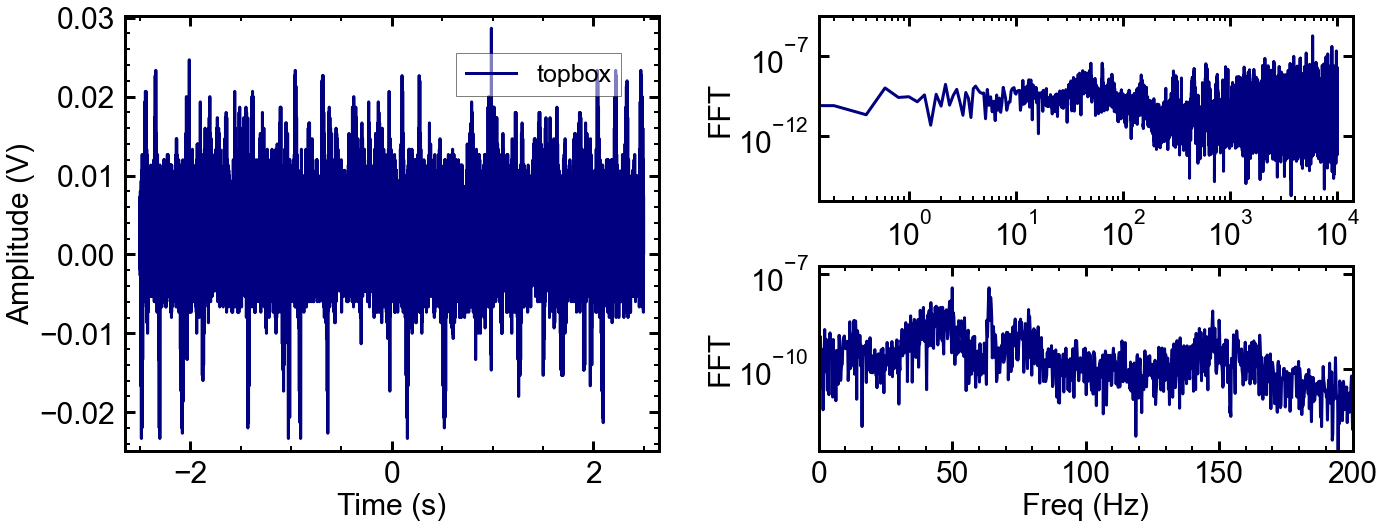

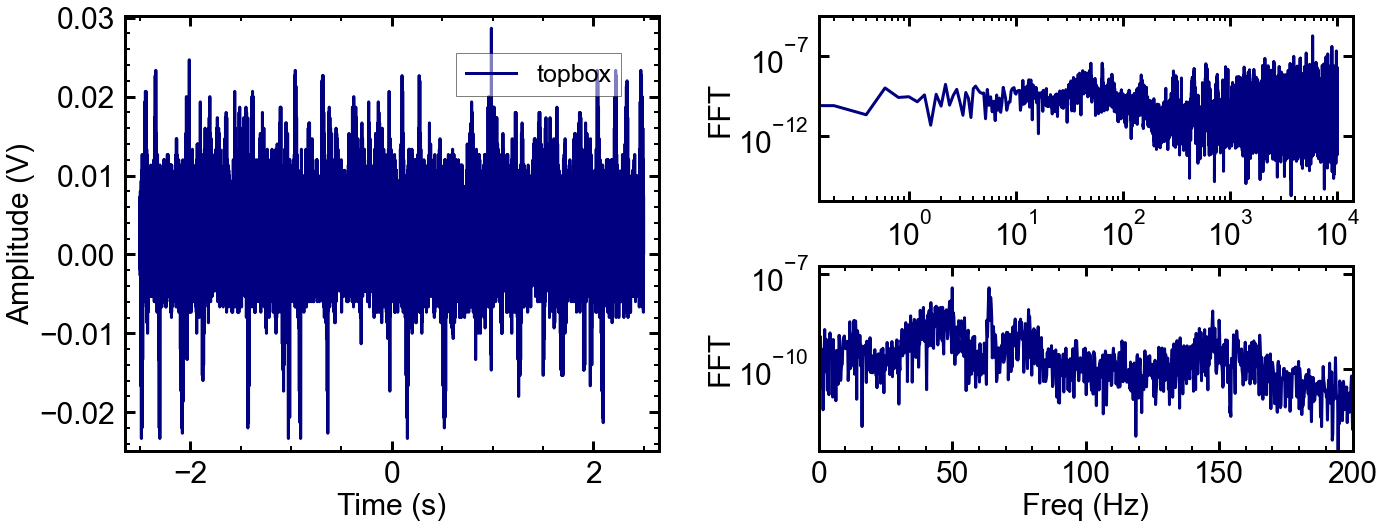

In [180]:
labels = ['topbox','opticaltable']
try:
    chn2x,chn2y,chn4x,chn4y = load_vibrometer_data(filename_vibration,isplot=True,labels=labels,issaved=not True)
    binx2,biny2= bin_logscale_data(chn2x,chn2y,retain=50,scale=20)
    binx4,biny4= bin_logscale_data(chn4x,chn4y,retain=50,scale=20)
except:
    chn2x,chn2y = load_vibrometer_data(filename_vibration,isplot=True,labels=labels,issaved=not True)
    binx2,biny2= bin_logscale_data(chn2x,chn2y,retain=50,scale=20)

Text(0.5, 1.0, '27042022vibration_data_optical table')

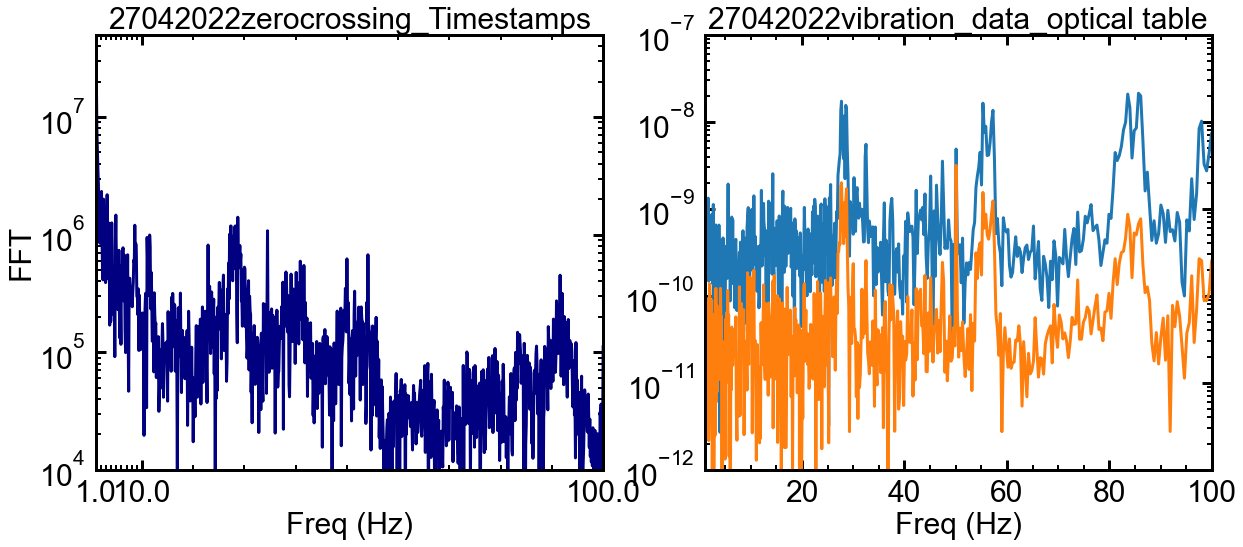

In [23]:
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax.plot(freq,normalisedfft,color='navy')
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1,100)
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel('FFT')
ax.set_ylim(10**4,5*10**7)
locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(1, 10) * .1,numticks=100)
ax.xaxis.set_major_locator(locmaj)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_title('27042022zerocrossing_Timestamps')


ax1 = f.add_subplot(122)
ax1.set_xlim(1,100)
ax1.plot(binx2,biny2)
ax1.plot(binx4,1e-1*biny4)
# ax1.plot(binx2,biny2,color='green')
ax1.set_xlabel('Freq (Hz)')
# ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.set_ylabel('FFT')
ax1.set_ylim(10**(-12),1*10**(-7))
ax1.set_title('27042022vibration_data_optical table')
# f.savefig(beat_data[:-4]+'_comparison_linear.png',dpi=100,bbox_inches='tight',facecolor='white')
# ax.yaxis.set_major_locator(locmaj)
# ax.yaxis.set_minor_locator(locmin)
# ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# Analysing the time tags itself

In [97]:
from fourier import fourier2
beat_directory = r'C:\Users\ZakKoong\Desktop\idqtimetaggerfiles'
# beat_file = os.path.join(beat_directory,'27042022zerocrossing_Timestamps_newclock_C1_1.txt')
beat_file = os.path.join(beat_directory,'06052022zerocrossing_Timestamps_off_C1_1.txt')
beat_file = os.path.join(beat_directory,'13052022zerocrossing_Timestamps_iondooropen_woodenboxdoorclosed_metalshieldlifted.txt')
beat_file = os.path.join(beat_directory,'20220517-093553_zerocrossing_Timestamps_normal.txt')
beat_signal_data = fasterloadtxt(beat_file) #* 1e-12
beat_signal_data -= beat_signal_data[0]

In [98]:
time_difference = np.diff(beat_signal_data)
freq_kHz = 1e-3/time_difference

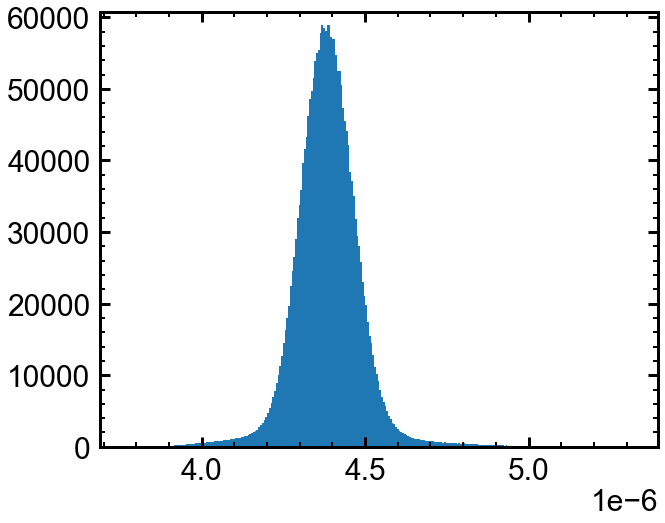

In [99]:
from Binning_scipy import bin_edge2_bin_center
binvalue,binedge,_ = plt.hist(time_difference,bins=300);
bincenter = bin_edge2_bin_center(binedge)
# res, mod = Gaussianfit(bincenter,binvalue)
# center = res.params['center'].value
# meanfreq = 1/center
# fwhm = res.params['fwhm'].value
# plt.plot(bincenter,res.best_fit)
# print (f'Mean frequency is {meanfreq:.5f} Hz')


# Phase difference between the data and an oscillator

In [100]:
length_data = len(beat_signal_data)

total_time = beat_signal_data[-1]
average_freq = (length_data-1)/total_time

phi = 2*np.pi*np.arange(length_data) # phase at time t
phi0= 2*np.pi*average_freq*beat_signal_data;   # phases of a perfectly stable oscillator
phase_diff = phi - phi0

phase_x = beat_signal_data
phase_y = phase_diff/2/np.pi
freq_phase,amp_phase = fourier2(phase_x,phase_y)
freq_phase_bin,amp_phase_bin = bin_logscale_data(freq_phase,amp_phase,retain=10,scale=100)

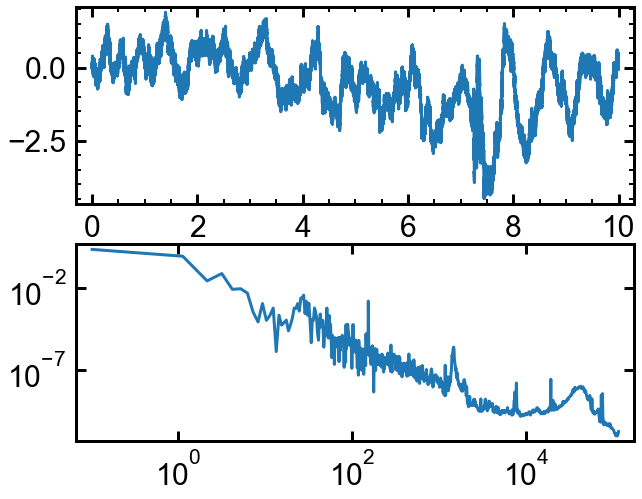

In [101]:
f = plt.figure()
ax = f.add_subplot(211)
ax.plot(beat_signal_data[:],phase_y[:])
ax1 = f.add_subplot(212)
ax1.loglog(freq_phase_bin[::10],amp_phase_bin[::10] )

## Estimate the Ramsey linewidth

In [102]:
class estimate_ramsey_linewidth:
    
    def __init__(self,beat_signal_data,phase_diff,display=False):
        '''
        Beat signal data in seconds
        '''
        self.timevector_ms = []
        self.contrast = []
        total_length = len(phase_diff)
        scan_range = np.concatenate([np.arange(4000)[::10],np.arange(4000,10000,1)[::10]])
        for i in scan_range:
            dphiin = phase_diff[:total_length-i][::i+1] - phase_diff[i:total_length][::i+1]
            _contrast = 0.71*np.sqrt(np.mean(np.cos(dphiin)-np.sin(dphiin))**2+np.mean(np.cos(dphiin)+np.sin(dphiin))**2)
            self.timevector_ms.append(beat_signal_data[i]*1000)
            self.contrast.append(_contrast)
        if display:
            self.fit_and_display()
            
    def fit_contrast(self,x,y):
        from lmfit import Model
        def fit_ramsey(t,fwhm,A,c):
            return A*np.exp(-(np.pi*fwhm*t)**2/(4*np.log(2)))+c
        mod = Model(fit_ramsey)
        params = mod.make_params(fwhm=120,A=1,c=0)
        params['fwhm'].set(min=0)
        params['c'].set(vary=False)
        params['A'].set(vary=False)
        start = np.searchsorted(x,0)
        end = np.searchsorted(x,3)
        result = mod.fit(y[start:end],params,t=x[start:end])
        return result, mod
    
    def fit_and_display(self):
        x = np.array(self.timevector_ms)*1e-3
        start = np.searchsorted(x,0)
        end = np.searchsorted(x,0.5)
        res,_mod = self.fit_contrast(x[start:end],self.contrast[start:end])
        print (res.fit_report())
        f = plt.figure()
        ax = f.add_subplot(111)
        ax.set_title(f'FWHM is {res.params["fwhm"].value:.1f} $\pm$ {res.params["fwhm"].stderr:.1f} Hz')
        ax.plot(self.timevector_ms,_mod.eval(res.params,t=np.array(self.timevector_ms)*1e-3),color='darkorange')
        ax.plot(self.timevector_ms,self.contrast,'o',color='navy')

        ax.set_xlim(0,50);
        ax.set_ylim(0,1)
        ax.set_xticks(np.arange(0,50,5));
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Contrast')

[[Model]]
    Model(fit_ramsey)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 1000
    # variables        = 1
    chi-square         = 10.5546296
    reduced chi-square = 0.01056519
    Akaike info crit   = -4549.19069
    Bayesian info crit = -4544.28294
[[Variables]]
    fwhm:  73.9652991 +/- 0.86762304 (1.17%) (init = 120)
    A:     1 (fixed)
    c:     0 (fixed)


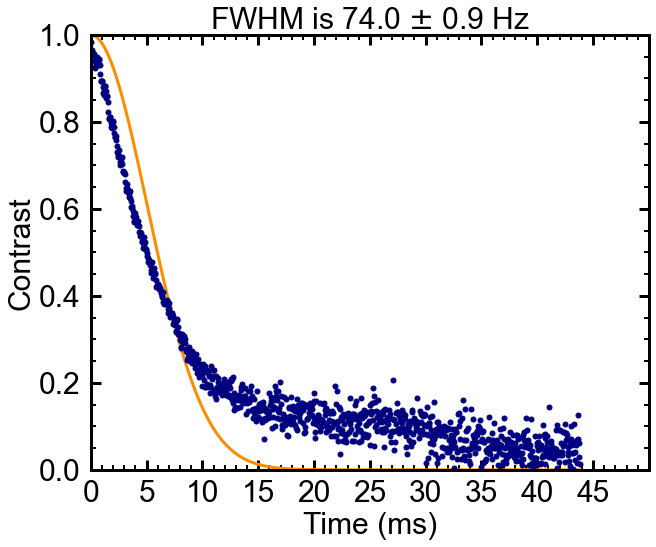

In [103]:
## fit data and display data

estimate_ramsey_linewidth(beat_signal_data,phase_diff,display=True)



# Count rate

In [30]:
def counts_timetrace(raw_data,total_time,binsize=1e-3):

    timebin = np.arange(binsize,np.ceil(total_time)+binsize/2,binsize)
    countbin = np.zeros(len(timebin))
    cnt = 0
    end_of_bin = timebin[cnt]

    for j in range(len(raw_data)):
        if raw_data[j] <= end_of_bin:
            countbin[cnt] += 1
        else:
            cnt += 1
            end_of_bin = timebin[cnt]
            if raw_data[j] <= end_of_bin:
                countbin[cnt] += 1
    return timebin,countbin
timebin,countbin = counts_timetrace(beat_signal_data,total_time=total_time,binsize=1e-5)

In [31]:
freq_timetrace,amp_timetrace = fourier2(timebin,countbin)
freq_timetrace_bin,amp_timetrace_bin = bin_logscale_data(freq_timetrace,amp_timetrace,retain=50,scale=500)

NameError: name 'chn2x' is not defined

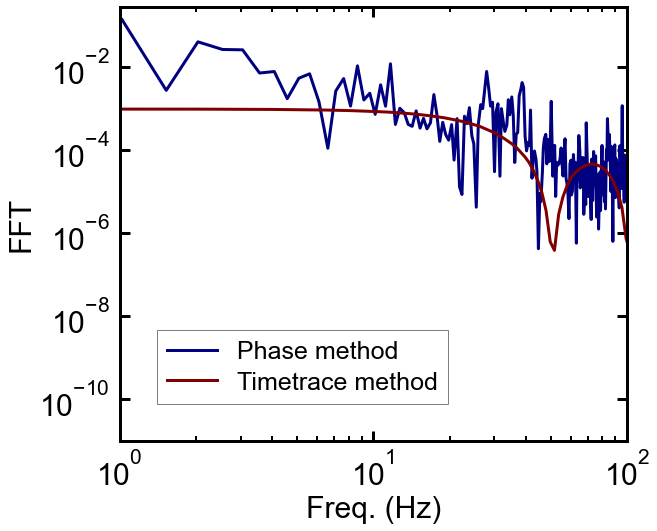

In [32]:
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax.loglog(freq_phase_bin,amp_phase_bin,label='Phase method',color='navy')
ax.loglog(freq_timetrace_bin,amp_timetrace_bin ,label='Timetrace method',color='maroon')
ax.legend(loc='best')
ax.set_xlabel('Freq. (Hz)')
ax.set_ylabel('FFT')
ax.set_xlim(1e0,1e2)

binx2,biny2= bin_logscale_data(chn2x,chn2y,retain=50,scale=100)
ax1 = f.add_subplot(122)
ax1.plot(binx2,biny2,color='green',label='Optical Table Vibration')
ax1.plot(freq_timetrace_bin,1e-2*amp_timetrace_bin ,label='Beat: Timetrace method',color='maroon')
ax1.legend(loc='best')
ax1.set_xlabel('Freq. (Hz)')
ax1.set_xlim(1e0,1e2)
ax1.set_xscale('log')
ax1.set_yscale('log')

(1.0, 1000.0)

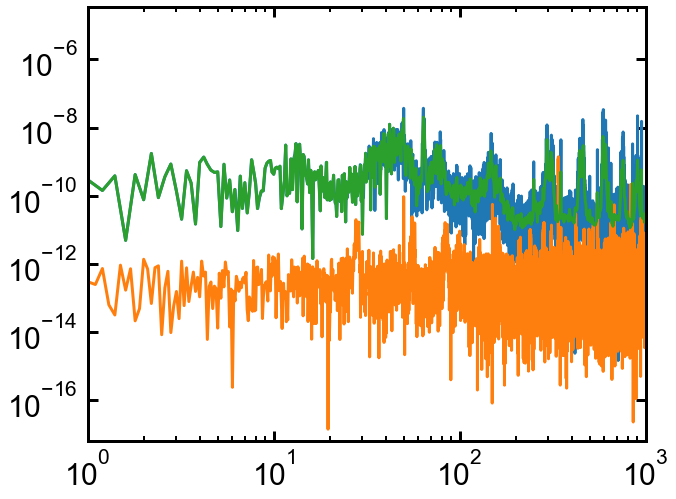

In [191]:
plt.plot(chn2x,chn2y)
plt.plot(chn4x,chn4y*1e-3)
binx2,biny2= bin_logscale_data(chn2x,chn2y,retain=20,scale=50)
plt.plot(binx2,biny2)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e0,1e3)

# display the data in linear scale

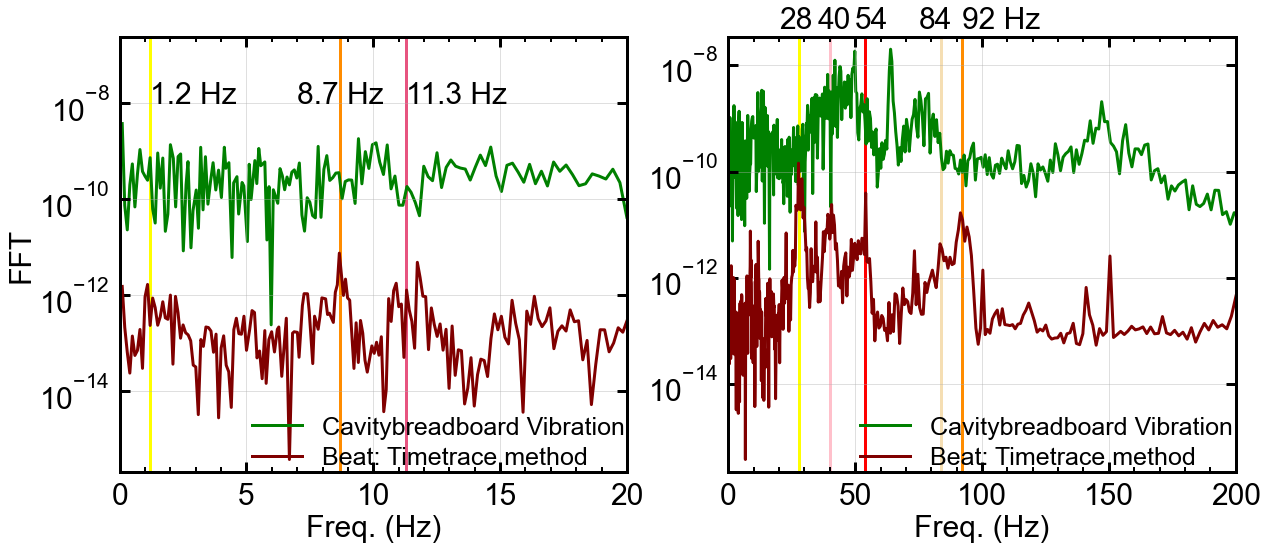

In [211]:
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax.plot(binx4,biny4,color='green',label='Cavitybreadboard Vibration',zorder=1)
ax.plot(freq_timetrace_bin,1e-3*amp_timetrace_bin ,label='Beat: Timetrace method',color='maroon',zorder=2)
ax.axvline(x=1.2,color='yellow',zorder=0,)
ax.axvline(x=8.7,color='darkorange',zorder=0,)
ax.axvline(x=11.3,color='#E75480',zorder=0,)
ax.text(1.2,1e-8,'1.2 Hz')
ax.text(7.,1e-8,'8.7 Hz')
ax.text(11.3,1e-8,'11.3 Hz')
ax.legend(loc='lower right',borderpad=0,borderaxespad=0.1,frameon=False)
ax.grid(alpha=0.5)
ax.set_xlabel('Freq. (Hz)')
ax.set_xlim(0,20)
ax.set_xscale('linear')
ax.set_yscale('log')
ax.set_ylabel('FFT')

ax1 = f.add_subplot(122)
ax1.plot(binx2,biny2,color='green',label='Cavitybreadboard Vibration',zorder=1)
ax1.plot(freq_timetrace_bin,1e-3*amp_timetrace_bin ,label='Beat: Timetrace method',color='maroon',zorder=2)
ax1.axvline(x=28,color='yellow',zorder=0)
ax1.axvline(x=40,color='pink',zorder=0)
ax1.axvline(x=54,color='red',zorder=0)
ax1.axvline(x=84,color='wheat',zorder=0)
ax1.axvline(x=92,color='darkorange',zorder=0)
ax1.text(20,5e-8,'28')
ax1.text(35,5e-8,'40')
ax1.text(50,5e-8,'54')
ax1.text(75,5e-8,'84')
ax1.text(92,5e-8,'92 Hz')
# ax.text(11.3,1e-8,'11.3 Hz')
ax1.legend(loc='lower right',borderpad=0,borderaxespad=0.1,frameon=False)
ax1.grid(alpha=0.5)
ax1.set_xlabel('Freq. (Hz)')
ax1.set_xlim(0,2e2)
ax1.set_xscale('linear')
ax1.set_yscale('log')

f.savefig(beat_file[:-4]+'_comparison_w_vibration.png',dpi=100,bbox_inches='tight',facecolor='white')

# Compare between beat fft files

In [54]:
directory = r'C:\Users\ZakKoong\Desktop\idqtimetaggerfiles'
filelist =glob1(directory,'*06052022*.txt')
filelist

['06052022zerocrossing_Timestampsbox_closed_C1.txt',
 '06052022zerocrossing_Timestampsbox_open_C1.txt',
 '06052022zerocrossing_Timestamps_1440Hz_C1_1.txt',
 '06052022zerocrossing_Timestamps_150Hz_C1_1.txt',
 '06052022zerocrossing_Timestamps_20Hz_C1_1.txt',
 '06052022zerocrossing_Timestamps_25Hz_C1_1.txt',
 '06052022zerocrossing_Timestamps_28Hz_C1.txt',
 '06052022zerocrossing_Timestamps_28Hz_C1_1.txt',
 '06052022zerocrossing_Timestamps_40Hz_C1_1.txt',
 '06052022zerocrossing_Timestamps_40Hz_C1_2.txt',
 '06052022zerocrossing_Timestamps_50Hz_C1_1.txt',
 '06052022zerocrossing_Timestamps_65Hz_C1_1.txt',
 '06052022zerocrossing_Timestamps_84Hz_C1_1.txt',
 '06052022zerocrossing_Timestamps_89Hz_C1_1.txt',
 '06052022zerocrossing_Timestamps_90Hz_C1_1.txt',
 '06052022zerocrossing_Timestamps_92Hz_C1_1.txt',
 '06052022zerocrossing_Timestamps_off_C1_1.txt']

In [158]:
class timetagging_beat:
    def __init__(self,filename,phase=True,plot=False):
        '''
        Input: beat filename
        phase = True (default) : execute the phase difference analysis
        
        Execute fft straightaway upon initialization.
        '''
        self.filename = filename
        self.timetags = self.fasterloadtxt()* 1e-12
        self.timetags -= self.timetags[0]
        self.length_data = len(self.timetags)
        self.total_time = self.timetags[-1]
        self.plot = plot
        self.average_freq = (self.length_data)/self.total_time
        if phase:
            self.mode = "Phase_difference"
            print ('Analysis mode is %s'%self.mode)
            self.phase_difference_timetrace()
        else:
            self.mode = "Time trace"
            print ('Analysis mode is %s'%self.mode)
            self.counts_timetrace()
    
    def getfftdata(self):
        if self.mode == "Phase_difference":
            return  self.freq_phase,self.amp_phase
        else:
            return  self.freq_count,self.amp_count
        
    def fasterloadtxt(self):
        '''
        using pandas to speed up file reading
        '''
        df = pd.read_csv(self.filename,sep=' ', header=None)
        return df.values.flatten()
    
    def plotfft(self,xlog=True,xlim=None,ylim=None,title=None):
        f = plt.figure()
        ax = f.add_subplot(111)
        if self.mode == "Phase_difference":
            ax.plot(self.freq_phase,self.amp_phase,'-',color='navy',lw=2.5)
            tempx = self.freq_phase
            tempy = self.amp_phase
        else:
            ax.plot(self.freq_count,self.amp_count,'-',color='navy',lw=2.5)
            tempx = self.freq_count
            tempy = self.amp_count
            
        ax.set_xlabel('Freq. (Hz)')
        ax.set_ylabel('FFT')
        ax.set_yscale('log')
        if xlim is not None:
            ax.set_xlim(xlim)
            start = np.searchsorted(tempx,xlim[0])
            end = np.searchsorted(tempx,xlim[-1])
            bottom = np.min(tempy[start:end])
            top = np.max(tempy[start:end])
            ax.set_ylim(bottom,top)
        if ylim is not None:
            ax.set_ylim(ylim)
        if xlog:
            ax.set_xscale('log')
            locmaj = matplotlib.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
            locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(1, 10) * .1,numticks=100)
            ax.xaxis.set_major_locator(locmaj)
            ax.xaxis.set_minor_locator(locmin)
            ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax.grid('on',which='both',alpha=0.5)
        if title is not None:
            ax.set_title(title)
        return f
        
    def phase_difference_timetrace(self):
        phi = 2*np.pi*np.arange(self.length_data) # phase at time t
        phi0= 2*np.pi*self.average_freq*self.timetags;   # phases of a perfectly stable oscillator
        self.phase_diff = phi - phi0

        phase_y = self.phase_diff/2/np.pi
        
        freq_phase,amp_phase = fourier2(self.timetags,phase_y)
        self.freq_phase,self.amp_phase = bin_logscale_data(freq_phase,amp_phase,retain=30,scale=1000)
        if self.plot:
            self.plotfft()
        
    def counts_timetrace(self,binsize=1e-5):
        raw_data = self.timetags
        timebin = np.arange(binsize,np.ceil(self.total_time)+binsize/2,binsize)
        countbin = np.zeros(len(timebin))
        cnt = 0
        end_of_bin = timebin[cnt]

        for j in range(len(raw_data)):
            if raw_data[j] <= end_of_bin:
                countbin[cnt] += 1
            else:
                cnt += 1
                end_of_bin = timebin[cnt]
                if raw_data[j] <= end_of_bin:
                    countbin[cnt] += 1
        freq_count,amp_count = fourier2(timebin,countbin)
        self.freq_count,self.amp_count = bin_logscale_data(freq_count,amp_count,retain=10,scale=500)
        if self.plot:
            self.plotfft()


In [163]:
freqvib = []
ampvib = []
drive = []
for j in range(len(filelist)):
    filename = os.path.join(directory,filelist[j])
    out = filelist[j]
    index = [i for i in findall('_', out)]
    keyword = out[index[1]+1:index[2]-2]
    try:
        drive.append(float(keyword))
    except Exception as ep:
        print (ep)
        drive.append(float('nan'))
    beatanalysis = timetagging_beat(filename,phase=False,plot=False)
    f = beatanalysis.plotfft(xlog=not True,xlim=(0.,2e2),ylim=None,title=filelist[j][:-4])
    saved_filename = os.path.join(r'Z:\qfc\users\Armin\timetagging_zerocrossing\06052022_qsimqfc_zerocrossing_timestamps',filelist[j])
#     f.savefig(saved_filename[:-4]+'_fft_phase.png',dpi=100,bbox_inches='tight',facecolor='white')
    _freq,_out = beatanalysis.getfftdata()
    freqvib.append(_freq)
    ampvib.append(_out)
    plt.close('all')

could not convert string to float: 'clos'
Analysis mode is Time trace
could not convert string to float: 'op'
Analysis mode is Time trace
Analysis mode is Time trace
Analysis mode is Time trace
Analysis mode is Time trace
Analysis mode is Time trace
Analysis mode is Time trace
Analysis mode is Time trace
Analysis mode is Time trace
Analysis mode is Time trace
Analysis mode is Time trace
Analysis mode is Time trace
Analysis mode is Time trace
Analysis mode is Time trace
Analysis mode is Time trace
Analysis mode is Time trace
could not convert string to float: 'o'
Analysis mode is Time trace


In [255]:
index = np.array([6,8,10,12,15,3])
np.array(drive)[index]

array([ 28.,  40.,  50.,  84.,  92., 150.])

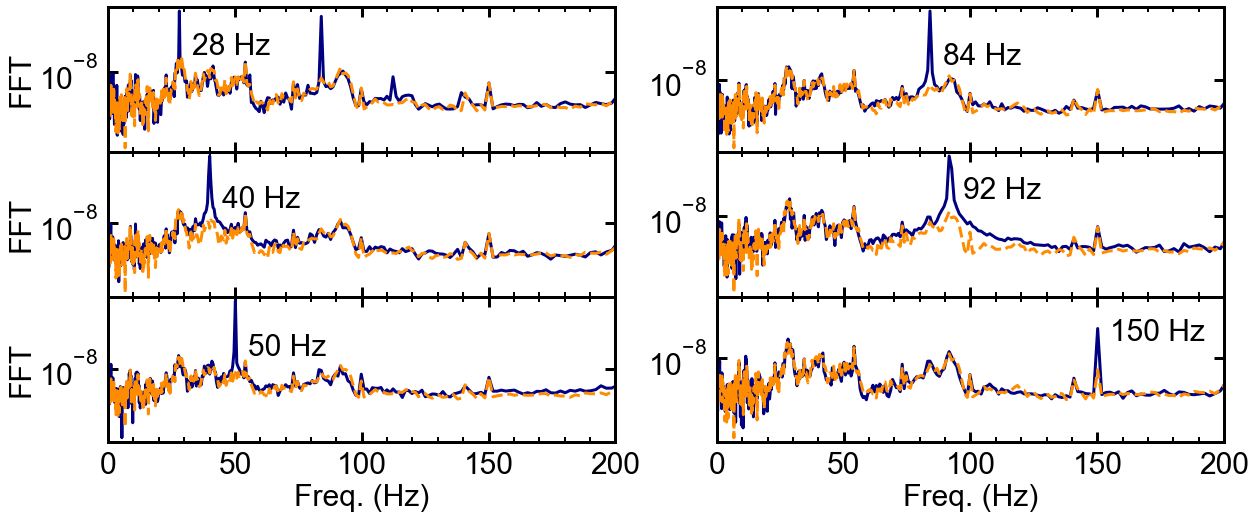

In [270]:
f = plt.figure(figsize=(20,8))
f.subplots_adjust(hspace=0)
ax = f.add_subplot(321)
ax1 = f.add_subplot(323)
ax2 = f.add_subplot(325)
ax3 = f.add_subplot(322)
ax4 = f.add_subplot(324)
ax5= f.add_subplot(326)
axlist = [ax,ax1,ax2,ax3,ax4,ax5]
ax2.set_xlabel('Freq. (Hz)')
ax5.set_xlabel('Freq. (Hz)')
ax.set_ylabel('FFT')
ax1.set_ylabel('FFT')
ax2.set_ylabel('FFT')
# ax3.set_ylabel('FFT')
ax.set_xlim(0,200)
ax1.set_xlim(0,200)
ax2.set_xlim(0,200)
ax3.set_xlim(0,200)
ax4.set_xlim(0,200)
ax5.set_xlim(0,200)
ax.set_yscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax5.set_yscale('log')
ax.set_xticklabels([])
ax1.set_xticklabels([])
# ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
cnt = 0
for j in index:
    axlist[cnt].plot(freqvib[j],ampvib[j],color='navy')
    axlist[cnt].text(drive[j]+5,1e-7,'%.0f Hz'%drive[j])
    axlist[cnt].plot(freqvib[-1],ampvib[-1],color='darkorange',ls='--')
    cnt += 1
# f.savefig(r'Z:\qfc\users\Armin\timetagging_zerocrossing\06052022_qsimqfc_zerocrossing_timestamps\06052022zerocrossing_Timestamps_modulation.png',
#          dpi=200,bbox_inches='tight', facecolor='white')